In [122]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
import math
from sklearn.metrics import mean_squared_error

In [123]:
dataPath = 'Data/2016-2019(One station)/shair-8781-1-6-1.csv'
airQualityData=pd.read_csv(dataPath, header=14,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('O3.*','O3',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('Black Carbon.*','Black Carbon',x), inplace = True)
airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
airQualityData= airQualityData.drop('Stop',axis=1)
one_feature=airQualityData.drop(columns=['Black Carbon','NO2','NOX','O3','PM2_5'])#
one_feature.head(5)
one_feature = one_feature.fillna(0)

In [124]:
# one_feature.loc[(one_feature['PM10'] <= 0, 'PM10')]=np.nan

In [125]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
scaled_down=one_feature.copy()
scaled_down['PM10']=sc.fit_transform(scaled_down['PM10'].values.reshape(-1, 1))

In [126]:
train=scaled_down[(scaled_down['Start']<= "2018-12-31 23:00:00")]
test=scaled_down[(scaled_down['Start'] >= "2019-01-01 00:00:00")]

In [127]:
train['predicted_pollution'] = train['PM10'].shift(-1)

# Drop the last row (it has no value for predicted pollution)
train = train.drop(train.tail(1).index)
train=train.drop('Start',axis=1)
train.head()

c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PM10,predicted_pollution
0,0.189614,0.069444
1,0.069444,0.070652
2,0.070652,0.081522
3,0.081522,0.091184
4,0.091184,0.094807


In [128]:
test['predicted_pollution'] = test['PM10'].shift(-1)

# Drop the last row (it has no value for predicted pollution)
test = test.drop(test.tail(1).index)
test=test.drop('Start',axis=1)

test.head()

c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PM10,predicted_pollution
35064,0.243357,0.102053
35065,0.102053,0.051329
35066,0.051329,0.039855
35067,0.039855,0.052536
35068,0.052536,0.044082


In [129]:
train_values=train.values
test_values=test.values
test_X, test_y = test_values[:, :-1], test_values[:, -1]
train_X, train_y = train_values[:, :-1], train_values[:, -1]

In [130]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [131]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50,
                    batch_size=72, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False)

Epoch 1/50
487/487 - 1s - loss: 0.0251 - val_loss: 0.0182
Epoch 2/50
487/487 - 1s - loss: 0.0163 - val_loss: 0.0169
Epoch 3/50
487/487 - 1s - loss: 0.0161 - val_loss: 0.0168
Epoch 4/50
487/487 - 1s - loss: 0.0161 - val_loss: 0.0168
Epoch 5/50
487/487 - 1s - loss: 0.0160 - val_loss: 0.0168
Epoch 6/50
487/487 - 1s - loss: 0.0159 - val_loss: 0.0168
Epoch 7/50
487/487 - 1s - loss: 0.0159 - val_loss: 0.0168
Epoch 8/50
487/487 - 1s - loss: 0.0159 - val_loss: 0.0168
Epoch 9/50
487/487 - 1s - loss: 0.0159 - val_loss: 0.0168
Epoch 10/50
487/487 - 1s - loss: 0.0159 - val_loss: 0.0168
Epoch 11/50
487/487 - 1s - loss: 0.0158 - val_loss: 0.0168
Epoch 12/50
487/487 - 1s - loss: 0.0158 - val_loss: 0.0168
Epoch 13/50
487/487 - 1s - loss: 0.0158 - val_loss: 0.0168
Epoch 14/50
487/487 - 1s - loss: 0.0158 - val_loss: 0.0168
Epoch 15/50
487/487 - 1s - loss: 0.0158 - val_loss: 0.0168
Epoch 16/50
487/487 - 1s - loss: 0.0158 - val_loss: 0.0168
Epoch 17/50
487/487 - 1s - loss: 0.0158 - val_loss: 0.0168
Epoch 

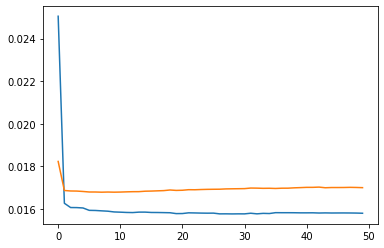

In [132]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')#orange is validation loss

In [137]:
# For Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
yhat = model.predict(test_X)


inv_yhat = sc.inverse_transform(yhat)



inv_y = sc.inverse_transform(test_y.reshape(-1, 1))


# Calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
'{:.3f}'.format(rmse)

'4.730'

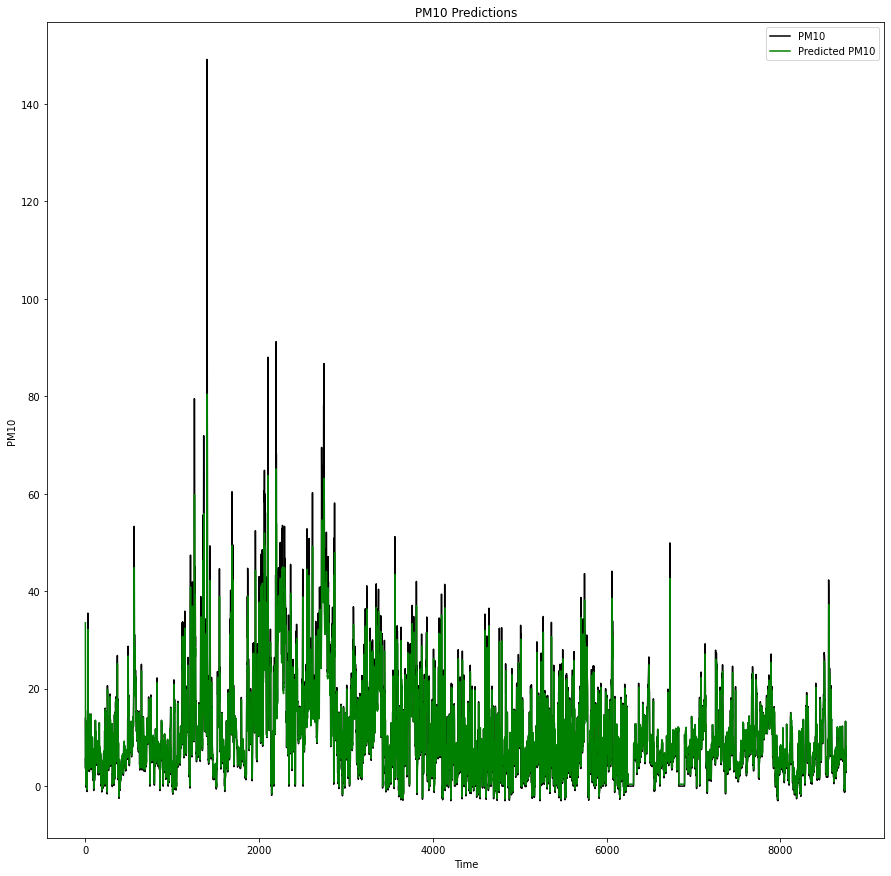

In [138]:

fig = plt.figure(figsize=(15,15))
plt.plot(inv_y, color = 'black', label = 'PM10')
plt.plot(inv_yhat, color = 'green', label = 'Predicted PM10')
plt.title('PM10 Predictions')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()
